# Sensor2Angle

### Step
1. Data Pre-processing
    - Minmax 归一化*
    - 滤波*
    - 加入DataLoader
2. Model Defination
    - LSTM
    - 滑动窗口
3. Training

4. Eval

## 1. Data Pre-processing
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Sampler, SubsetRandomSampler, SequentialSampler
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, utils
from sklearn.preprocessing import StandardScaler
from utils import savgol

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [98]:
class BatchSampler(Sampler):
    r"""Wraps another sampler to yield a mini-batch of indices.
    Args:
        sampler (Sampler): Base sampler.
        batch_size (int): Size of mini-batch.
        drop_last (bool): If ``True``, the sampler will drop the last batch if
            its size would be less than ``batch_size``
    """
# 批次采样
    def __init__(self, sampler, batch_size, drop_last):
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of "
                             "torch.utils.data.Sampler, but got sampler={}"
                             .format(sampler))
        if not isinstance(batch_size, _int_classes) or isinstance(batch_size, bool) or \
                batch_size <= 0:
            raise ValueError("batch_size should be a positive integeral value, "
                             "but got batch_size={}".format(batch_size))
        if not isinstance(drop_last, bool):
            raise ValueError("drop_last should be a boolean value, but got "
                             "drop_last={}".format(drop_last))
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last

    def __iter__(self):
        batch = []
        for idx in self.sampler:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size    

        
class Sensor2AngleDataset(Dataset):
    """Sensor to Angle Dataset."""

    def __init__(self, seq_len, do_standardize=True, do_filter=True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.x, self.y = sliding_windows(seq_len, do_standardize, do_filter)
    
    def __len__(self):
        assert(self.x.shape[0] == self.y.shape[0])
        return self.x.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # sensor data
        sensor = self.x[idx]
        # angle data
        angle = self.y[idx]
        sample = {'sensor': sensor, 'angle': angle}
            
        return sample

    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sensor, angle = sample['sensor'], sample['angle']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        return {'sensor': torch.from_numpy(sensor),
                'angle': torch.from_numpy(angle)}


def sliding_windows(seq_len, do_standardize=True, do_filter=True):
    with open('data/sensor.npy', 'rb') as f:
        sensor = np.load(f)
    with open('data/angle.npy', 'rb') as f:
        angle = np.load(f)
    if do_standardize:
        scaler = StandardScaler()                          #实例化
#         scaler = MinMaxScaler()
        sensor = scaler.fit_transform(sensor)              #使用fit_transform(data)一步达成结果
        print("MEAN and VAR: ", scaler.mean_, scaler.var_)
#         angle = scaler.fit_transform(angle)
#         scaler.fit(sensor)                      #fit，本质是生成均值和方差
#         print(scaler.mean_)                     #查看均值的属性mean_
#         print(scaler.var_)                      #查看方差的属性var_
#         x_std = scaler.transform(sensor)        #通过接口导出结果
#         print(x_std.mean())                     #导出的结果是一个数组，用mean()查看均值
#         print(x_std.std())                      #用std()查看方差
#         scaler.inverse_transform(x_std)         #使用inverse_transform逆转标准化
    if do_filter:
        for i in range(sensor.shape[1]):
            sensor[:,i] = savgol(sensor[:,i], 51, 2, do_plot=True)
        for i in range(angle.shape[1]):
            angle[:,i] = savgol(angle[:,i], 51, 2, do_plot=True)
    
    x = []
    y = []
    assert(sensor.shape[0] == angle.shape[0])
    num_sample = sensor.shape[0]
    for i in range(num_sample-seq_len+1):
        _x = sensor[i:(i+seq_len)]
        _y = angle[i+seq_len-1]
        x.append(_x)
        y.append(_y)
        
    return [np.array(x), np.array(y)]

In [99]:
# dataset_path = 'data/processing/QianquForward.csv'
# data_frame = pd.read_csv(dataset_path)
# num_sample = data_frame.shape[0]
# data_frame.dropna(inplace=True)
# data_frame.reset_index(drop=True, inplace=True)
# data_frame = data_frame.iloc[:,-14:]
# sensor = np.array([data_frame.iloc[:, -5:]]).astype('float').squeeze()
# angle = np.array([data_frame.iloc[:, -14:-8]]).astype('float').squeeze()

MEAN and VAR:  [104.48163846 112.59508134  45.60365677  99.85794248 113.66390261] [1186.24965705  213.88620244  199.81834763   62.33740448   11.24210904]


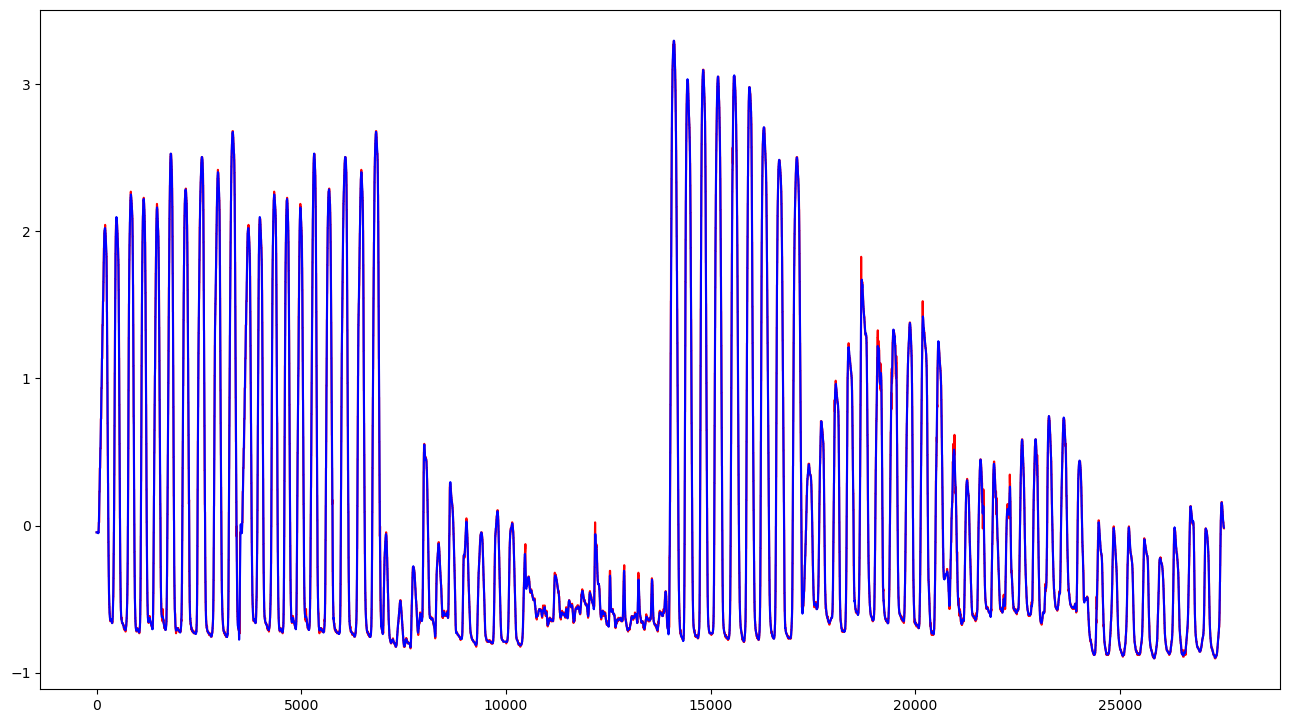

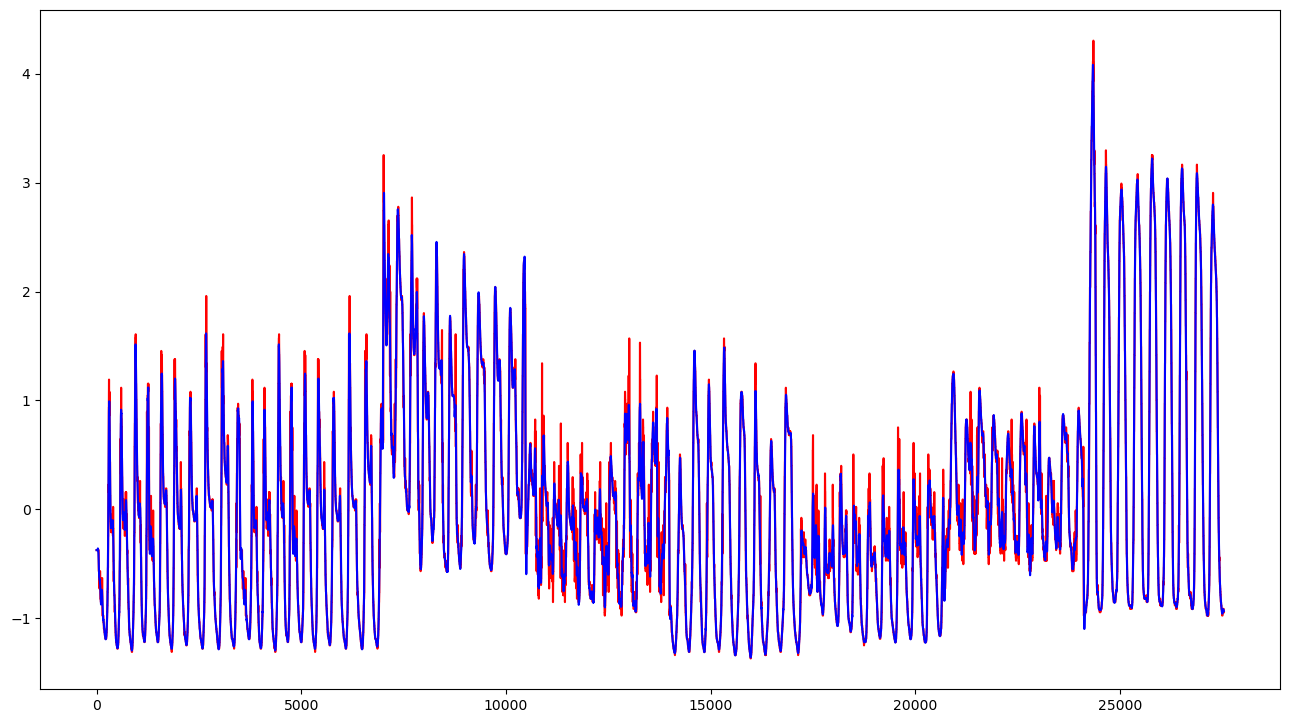

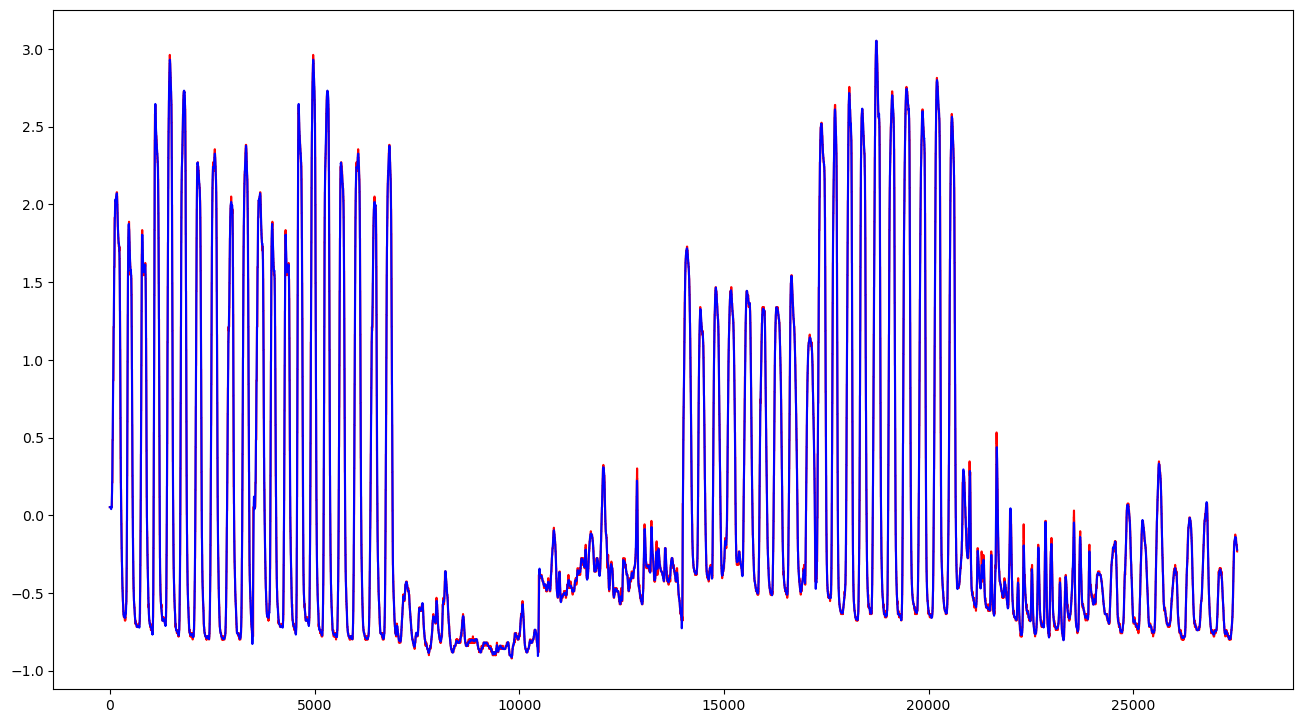

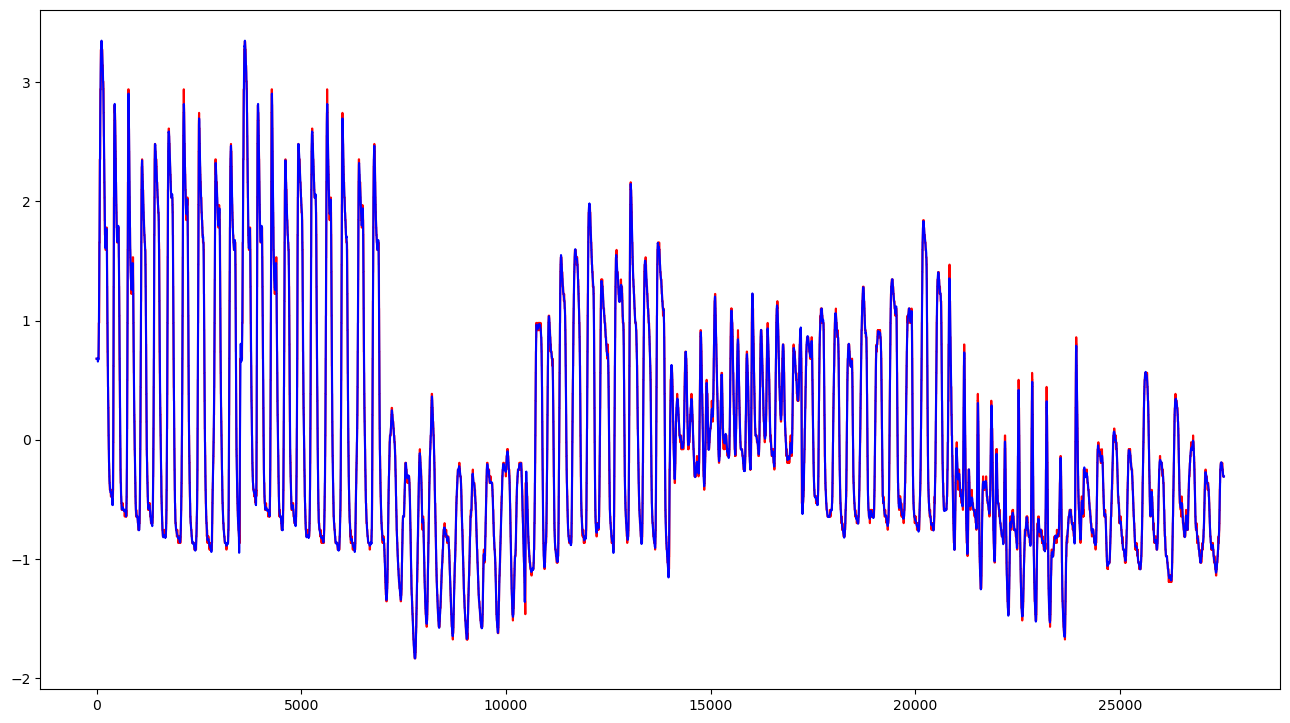

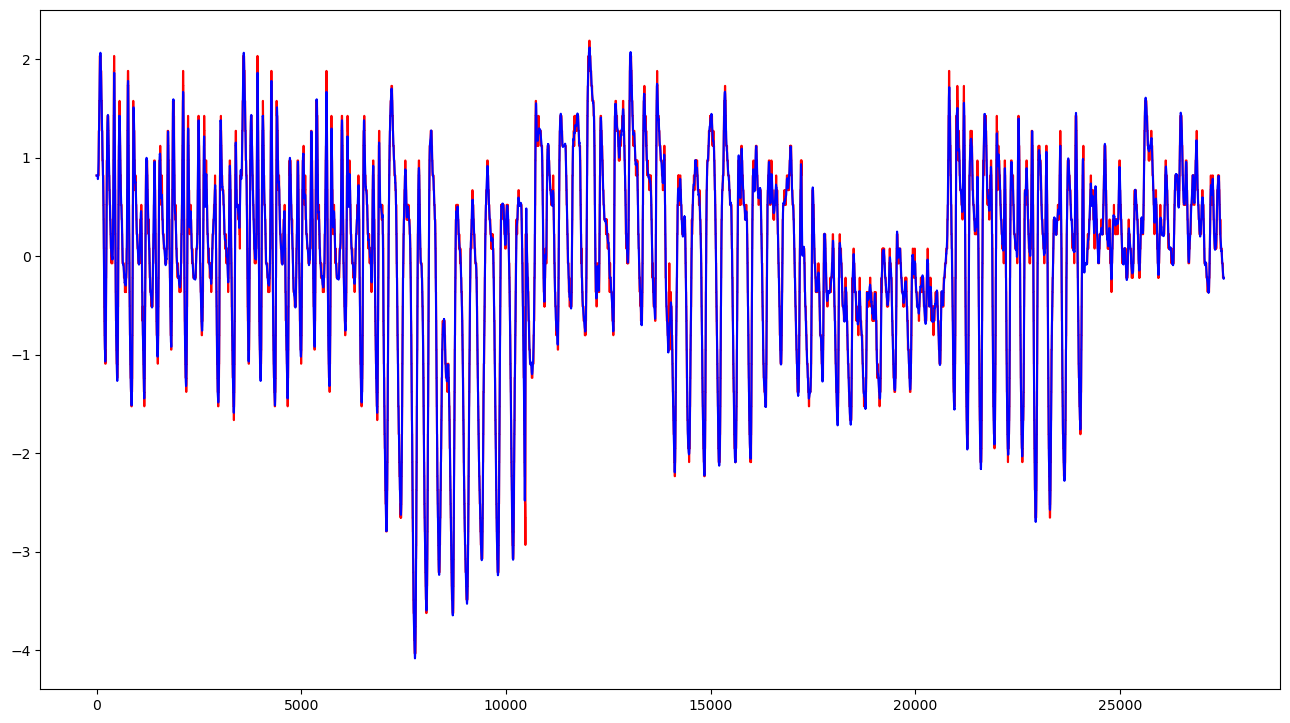

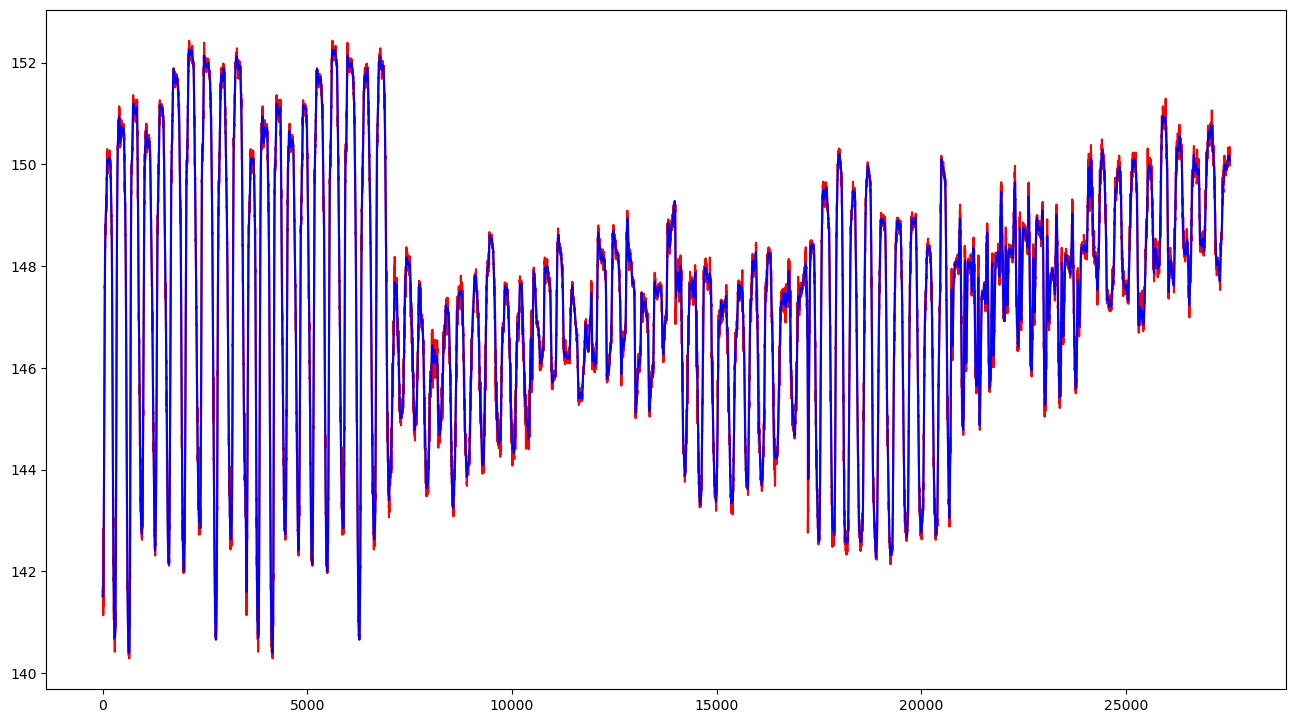

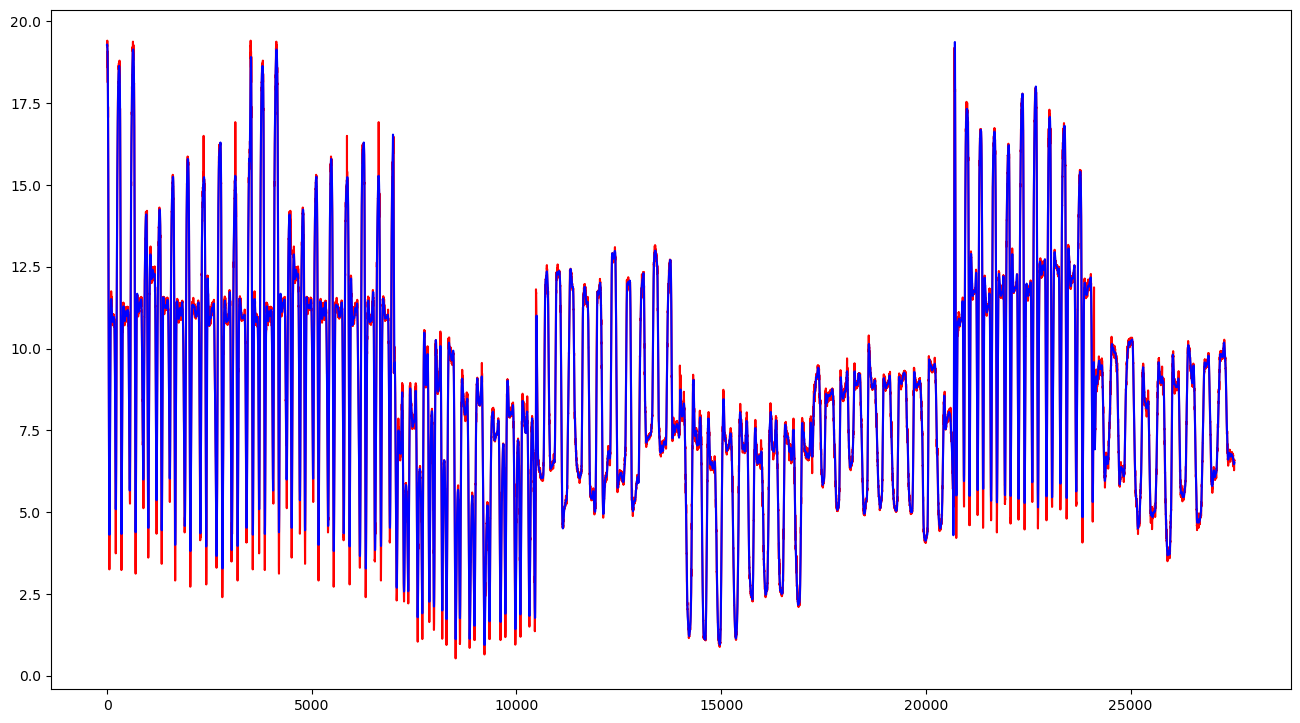

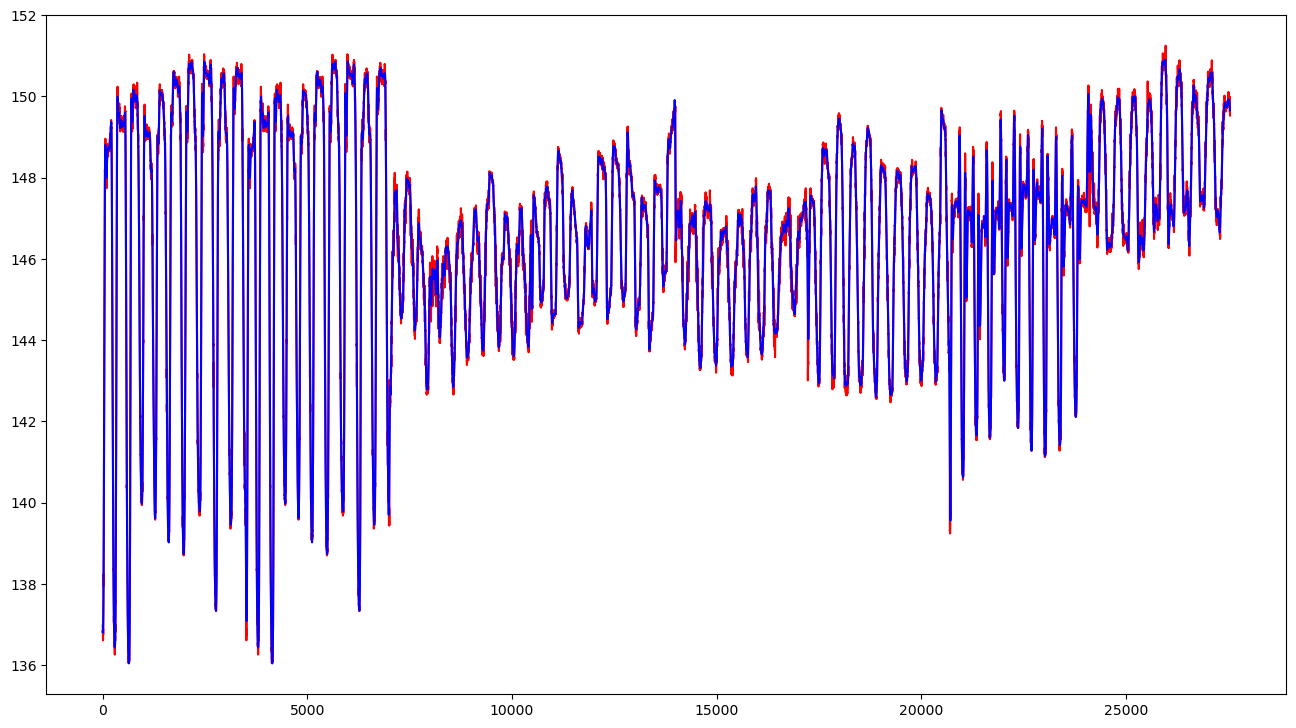

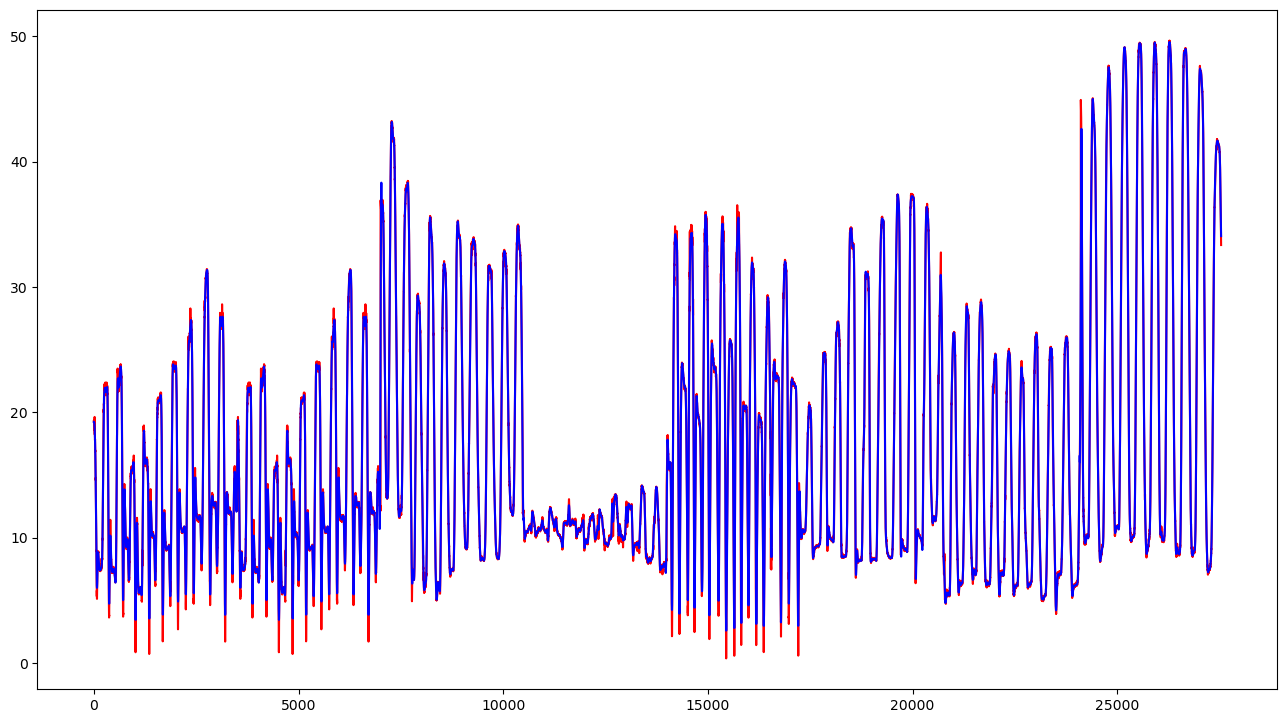

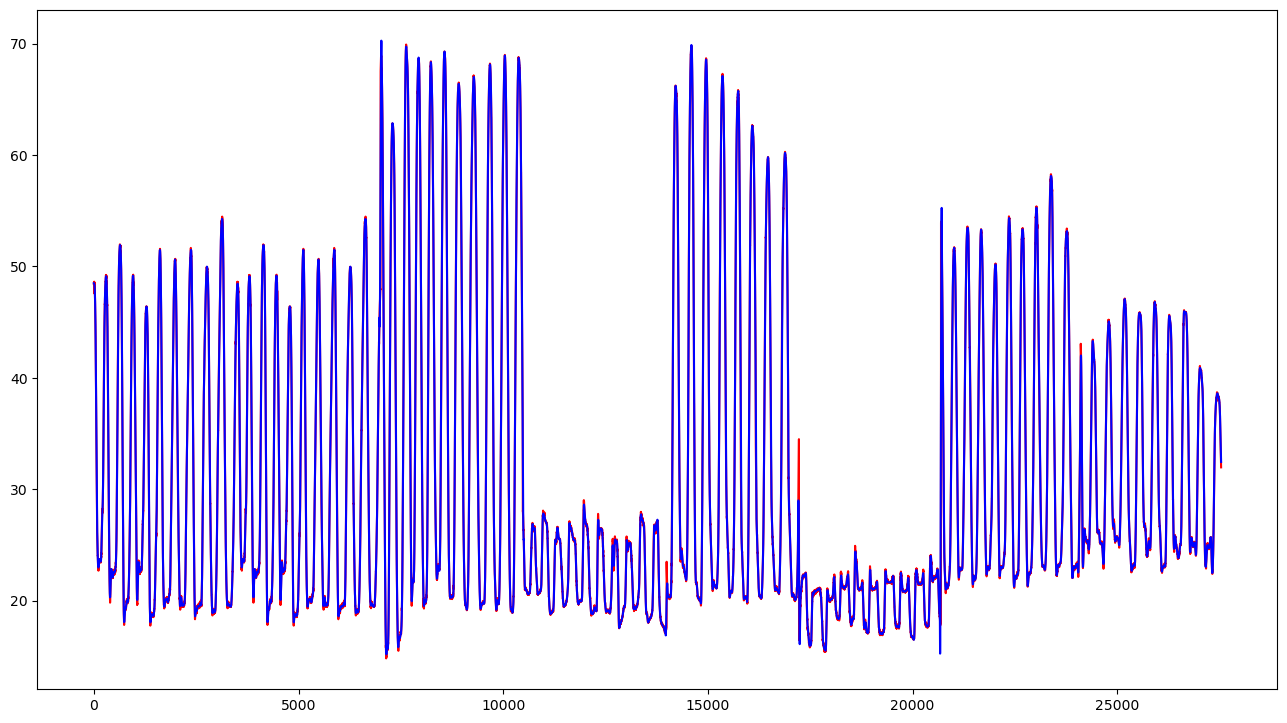

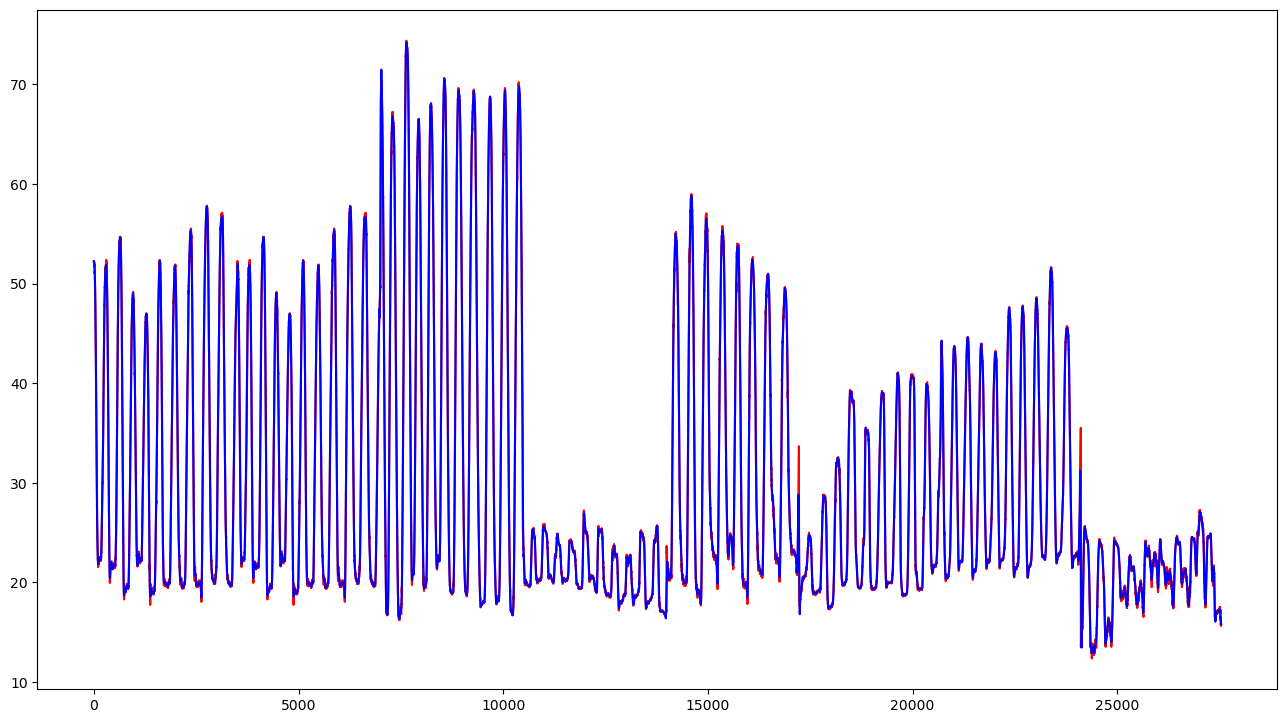

In [100]:
batch_size = 32
validation_split = .05
random_seed= 43
seq_len = 120

# torch.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed)

# Creating data indices for training and validation splits:
dataset = Sensor2AngleDataset(seq_len, do_standardize=True, do_filter=True)
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
test_sampler = SequentialSampler(test_indices)

# sc = MinMaxScaler()
# dataset = sc.fit_transform(training_set)
train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler, 
                                           shuffle=False, 
                                           num_workers=0, 
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader( dataset, 
                                           batch_size=batch_size, 
                                           sampler=test_sampler, 
                                           shuffle=False, 
                                           num_workers=0, 
                                           drop_last=True)

In [101]:
for i,data in enumerate(train_loader):
    print(data['sensor'].size())
    print(data['angle'].size())
    break

torch.Size([32, 120, 5])
torch.Size([32, 6])


## 2. Model Defination
#### Time Series Regression Model:
- LSTM
- Transformer
- WaveNet

In [6]:
class LSTM(nn.Module):

    def __init__(self, batch_size, inp_dim, mid_dim, num_layers, out_dim, seq_len):
        super(LSTM, self).__init__()
        self.liner_hidden_1 = 512
        self.liner_hidden_2 = 256
        self.liner_hidden_3 = 128
        self.liner_hidden_4 = 64
        
        self.rnn = nn.LSTM(inp_dim, mid_dim, num_layers, batch_first=True).to(device)
        # inp_dim 是LSTM输入张量的维度，我们已经根据我们的数据确定了这个值是3
        # mid_dim 是LSTM三个门 (gate) 的网络宽度，也是LSTM输出张量的维度
        # num_layers 是使用两个LSTM对数据进行预测，然后将他们的输出堆叠起来。
        self.reg = nn.Sequential(
            nn.Linear(mid_dim * seq_len, self.liner_hidden_1),
            nn.ReLU(),
            nn.Linear(self.liner_hidden_1, self.liner_hidden_2),
            nn.ReLU(),
            nn.Linear(self.liner_hidden_2, self.liner_hidden_3),
            nn.ReLU(),
            nn.Linear(self.liner_hidden_3, self.liner_hidden_4),
            nn.ReLU(),
            nn.Linear(self.liner_hidden_4, out_dim),
        )  # regression

    def forward(self, x):
        h0 = torch.zeros(num_layers, batch_size, out_dim).to(device) #(num_layers,batch,output_size)
        c0 = torch.zeros(num_layers, batch_size, out_dim).to(device) #(num_layers,batch,output_size)
        output, (hn, cn) = self.rnn(x, (h0, c0))
        output = output.contiguous().view(batch_size, -1)
        output = self.reg(output)
        
        return output
    
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

## 3. Training


In [7]:
inp_dim = 5
mid_dim = 6
num_layers = 2
out_dim = 6
num_epochs = 1000
learning_rate = 0.001

lstm = LSTM(batch_size, inp_dim, mid_dim, num_layers, out_dim, seq_len).to(device)
print(get_parameter_number(lstm))
# criterion = torch.nn.MSELoss(reduction='sum')    # mean-squared error for regression
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.1, last_epoch=-1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

{'Total': 542670, 'Trainable': 542670}


In [8]:
# Train the model
min_loss = 100000 #随便设置一个比较大的数
min_save_epoch = 100
for epoch in range(num_epochs):
    for index, data in enumerate(train_loader):
        trainX = data['sensor'].float().to(device)
        trainY = data['angle'].float().to(device)
        optimizer.zero_grad()
        outputs = lstm(trainX)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
#     scheduler.step()
    if loss < min_loss and epoch > min_save_epoch:
        min_loss = loss
        print("save model")
        torch.save(lstm.state_dict(), 'model/model.pth')
        
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
print('===end===')

Epoch: 0, loss: 79.18040
Epoch: 10, loss: 108.28741
Epoch: 20, loss: 99.64404
Epoch: 30, loss: 59.29741
Epoch: 40, loss: 54.08975
Epoch: 50, loss: 47.79320
Epoch: 60, loss: 46.46072
Epoch: 70, loss: 48.05460
Epoch: 80, loss: 39.19239
Epoch: 90, loss: 39.70042
Epoch: 100, loss: 35.60704
save model
save model
save model
save model
save model
save model
Epoch: 110, loss: 34.49448
save model
save model
save model
save model
save model
save model
save model
Epoch: 120, loss: 33.39151
save model
save model
save model
save model
save model
save model
save model
Epoch: 130, loss: 33.91248
save model
save model
Epoch: 140, loss: 33.66777
save model
Epoch: 150, loss: 32.17830
save model
save model
Epoch: 160, loss: 31.89268
save model
save model
save model
save model
save model
save model
save model
Epoch: 170, loss: 29.93890
save model
save model
save model
save model
save model
Epoch: 180, loss: 29.74313
save model
save model
save model
save model
save model
Epoch: 190, loss: 29.34936
save mod

## 4. Visualization

In [79]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

x_test = list()
label = list()
predict = list()
loss_list = list()

lstm.load_state_dict(torch.load('model/model.pth', map_location=device), strict=False)
lstm.eval()
for index, data in enumerate(train_loader):
    x_ = data['sensor'].float().to(device)
    y_ = data['angle'].float().data.numpy()
    p_ = lstm(x_).cpu().data.numpy()
    x_test.append(list(x_.cpu().data.numpy()[:,-1,:]))
    label.append(y_)
    predict.append(p_)
    
    trainX = data['sensor'].float().to(device)
    trainY = data['angle'].float().to(device)
    outputs = lstm(trainX)
    loss = criterion(outputs, trainY)
    loss_list.append(loss.item())
    
print('mean loss:', np.array(loss_list).mean())
x_test = np.array(x_test).reshape(-1, 5)
label = np.array(label).reshape(-1, 6)
predict = np.array(predict).reshape(-1, 6)
label_names = ['AA_SN_X', 'AA_SN_Y', 'AA_SN_Z', 'GH_AA_X', 'GH_AA_Y', 'GH_AA_Z']

mean loss: 2.5935808742551605


### angle prediction plot

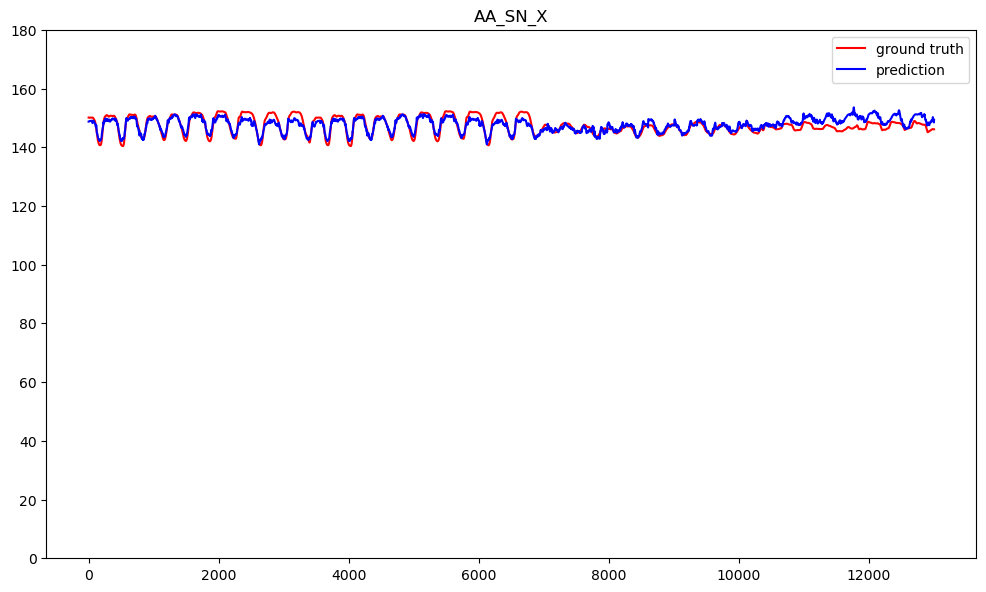

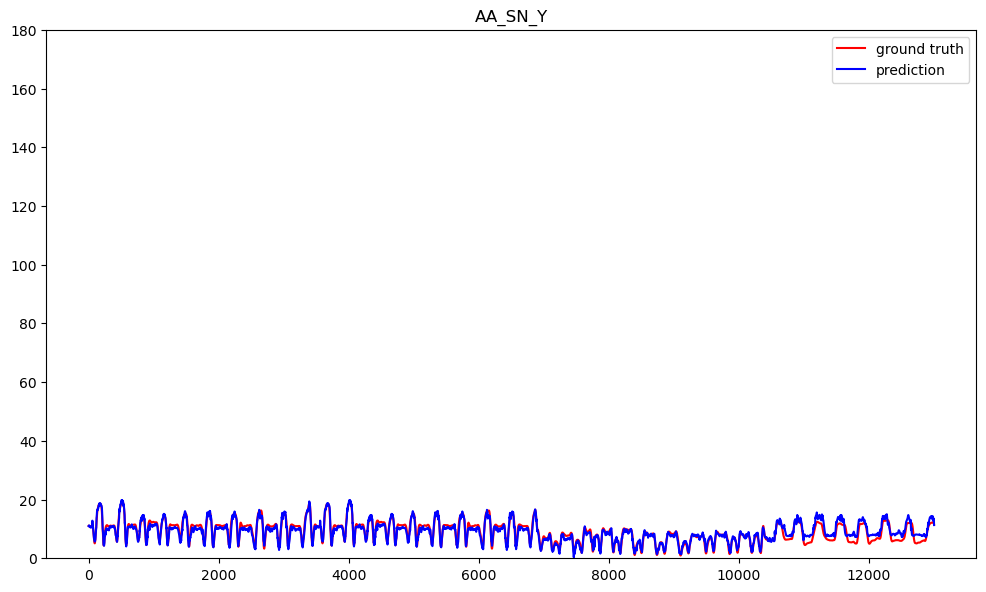

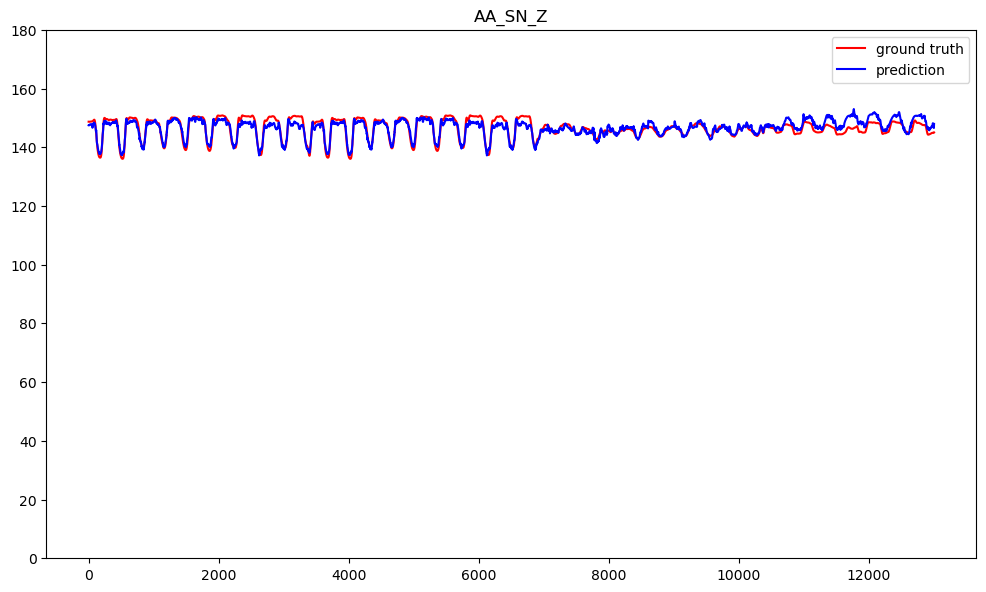

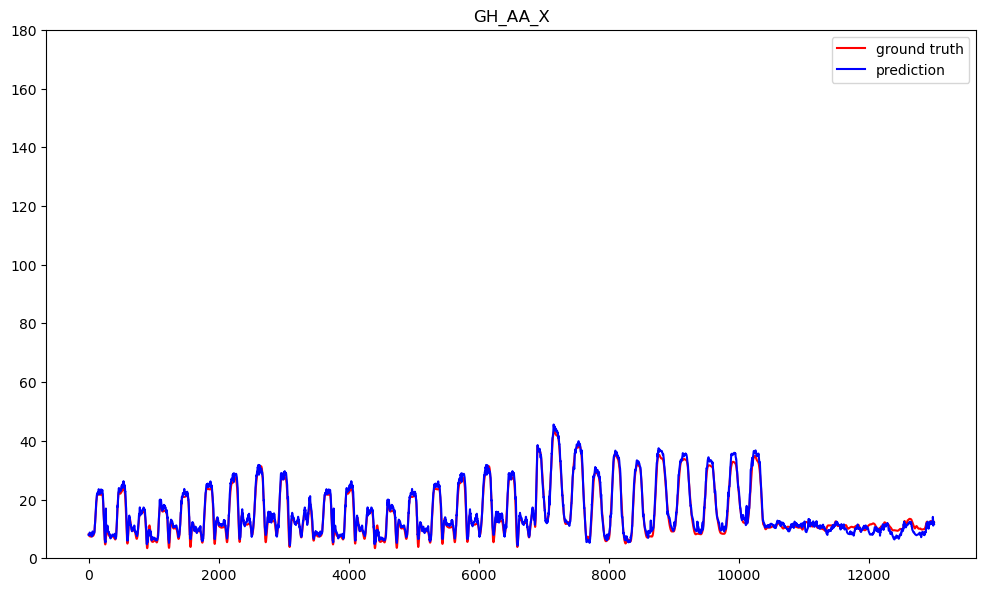

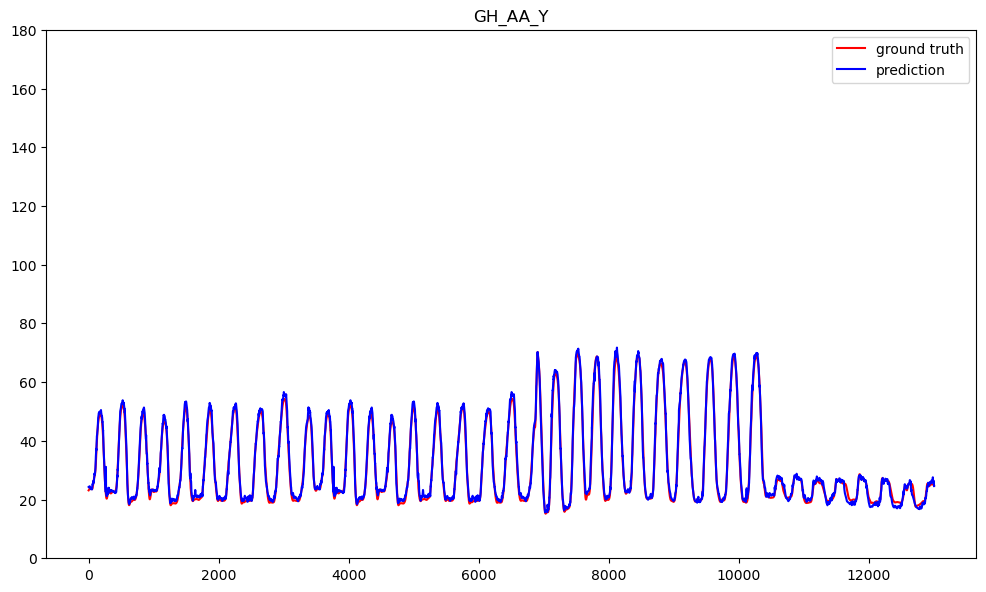

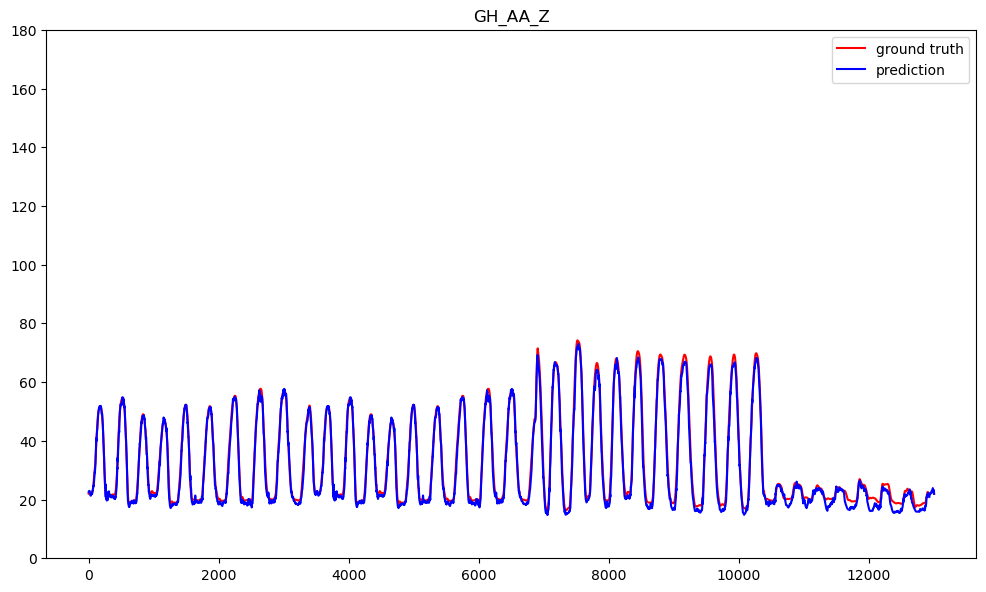

In [107]:
step = 13000

# figure(figsize=(12, 7), dpi=100)
for i in range(6):
    figure(figsize=(12, 7), dpi=100)
    plt.plot(label[0:step,i], color='r', label='ground truth')
    plt.plot(predict[0:step,i], color='b', label='prediction')
    plt.title(label_names[i])
    axes = plt.gca()
    axes.set_ylim([0,180])
    plt.legend()
#     plt.savefig(f'result/test/test_{label_names[i]}.png')
plt.show()

## sensor plot

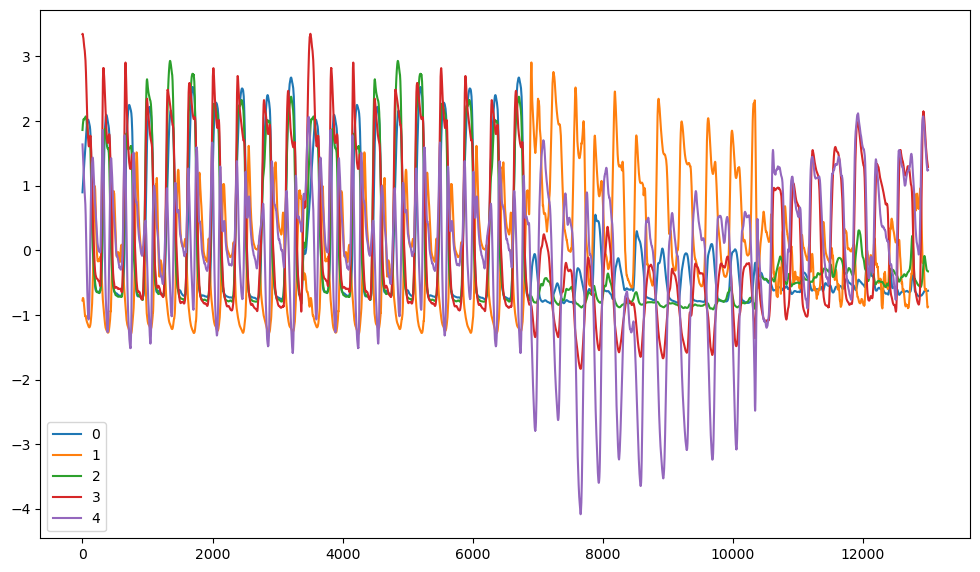

In [108]:
figure(figsize=(12, 7), dpi=100)
for i in range(5):
#     figure(figsize=(12, 7), dpi=100)
    plt.plot(x_test[0:step,i], label=i)
    axes = plt.gca()
    plt.legend()
    
plt.show()

## Real time testing

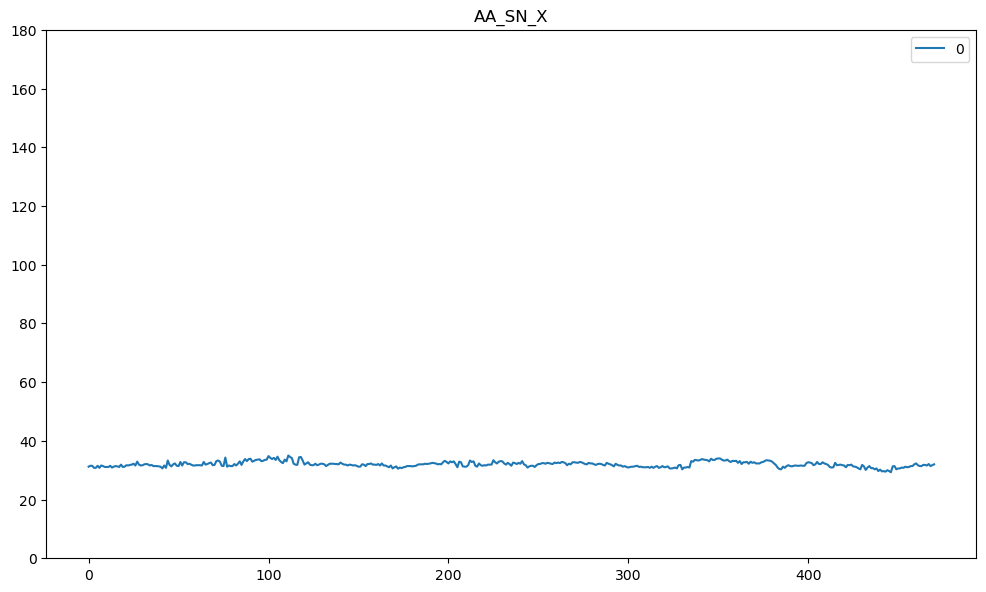

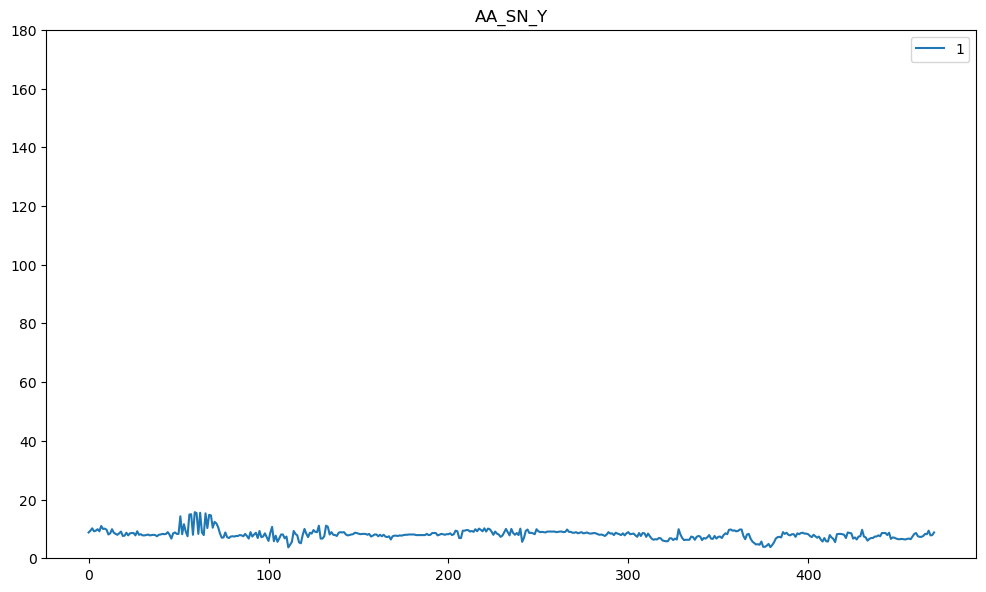

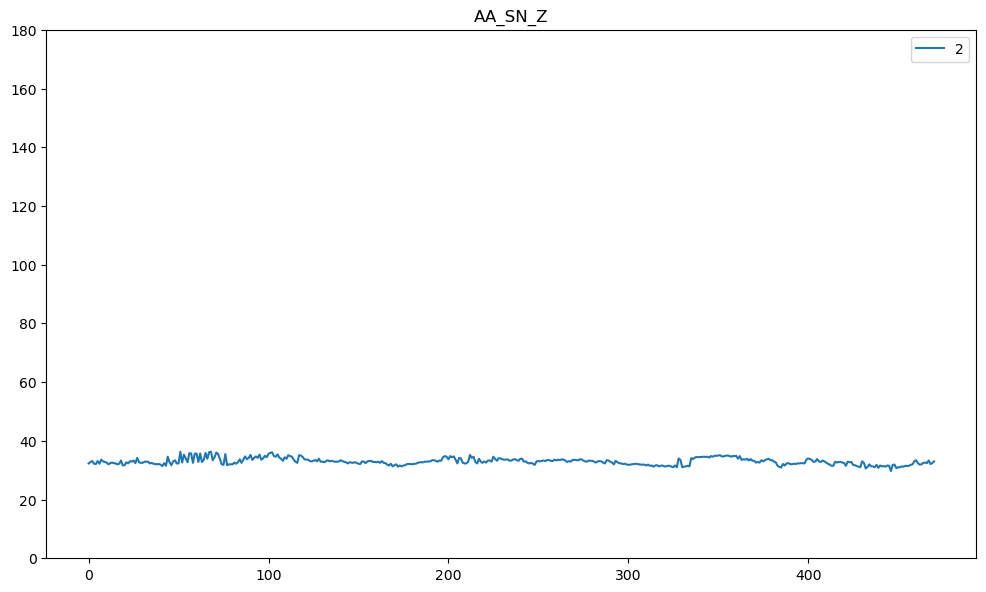

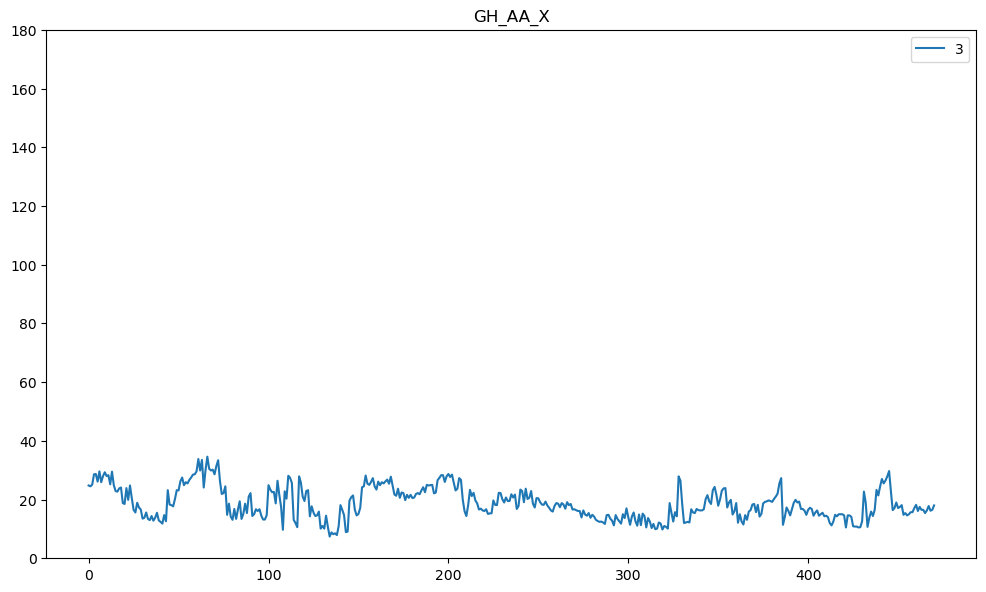

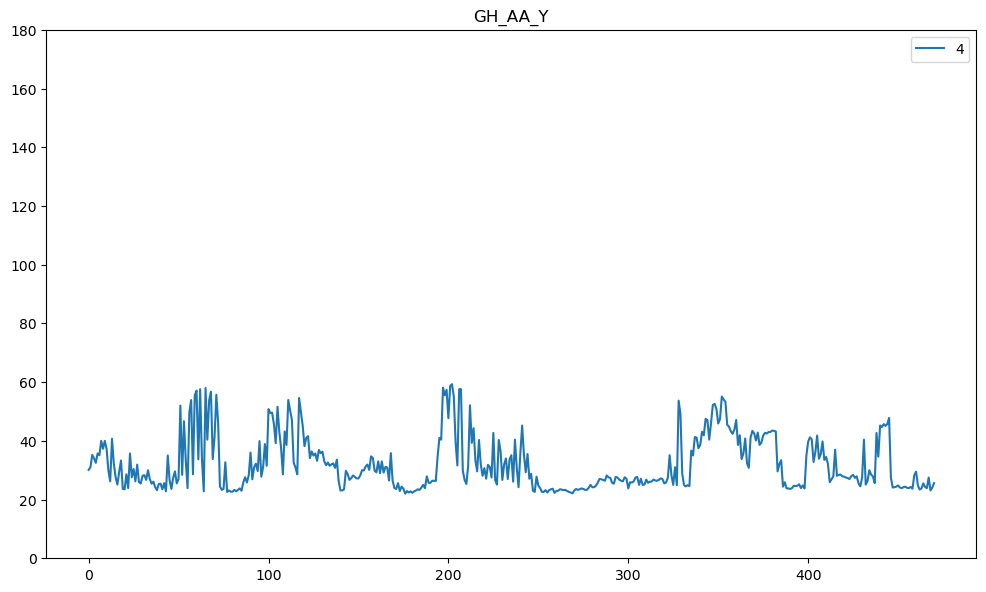

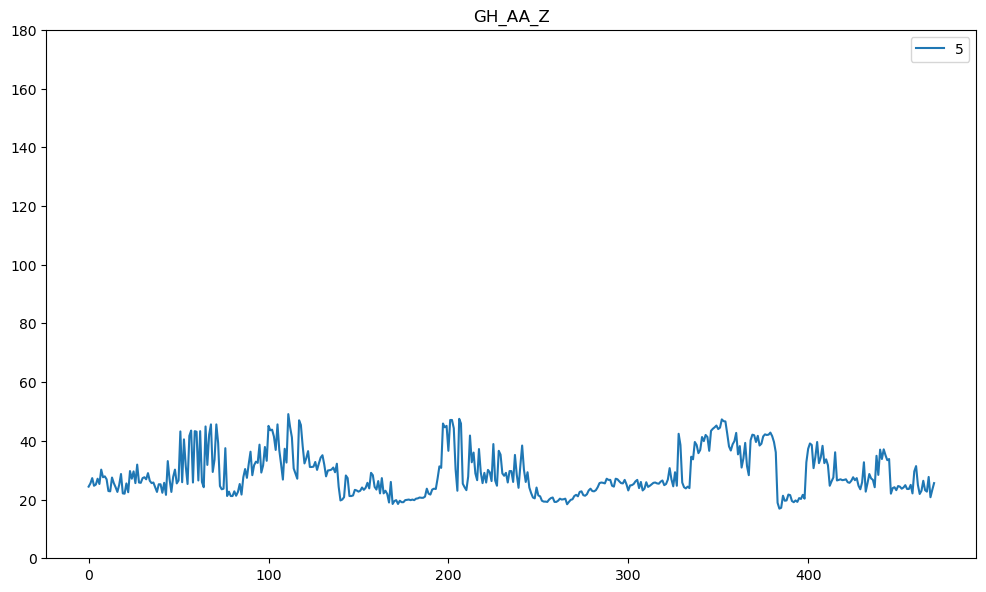

In [125]:
angle_test = np.load('data/testing/Angle_2021-07-14-14-09-29.npy')
for i in range(6):
    figure(figsize=(12, 7), dpi=100)
    plt.plot(angle_test[:,i], label=i)
    plt.title(label_names[i])
    axes = plt.gca()
    axes.set_ylim([0,180])
    plt.legend()
#     plt.savefig(f'result/test/test_{label_names[i]}.png')
plt.show()